# Importing required packages

In [295]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import KNNImputer

# Read data

In [170]:
data = pd.read_csv('bankruptcy.csv')
data.head()
data.shape

(10503, 65)

# Check null/NA Values

In [171]:
data.isnull().sum().nlargest(10)

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
dtype: int64

# Impute Missing Values using KNNImputer

In [178]:
imputer = KNNImputer(n_neighbors=10, weights="uniform")
data_impute = data.drop('class', axis = 1)
imputed_data = imputer.fit_transform(data_impute)
imputed_data_df = pd.DataFrame(imputed_data, index=data_impute.index, columns=data_impute.columns)

In [186]:
data = pd.concat([imputed_data_df, data['class']], axis = 1)
data.isnull().sum()

Attr1     0
Attr2     0
Attr3     0
Attr4     0
Attr5     0
         ..
Attr61    0
Attr62    0
Attr63    0
Attr64    0
class     0
Length: 65, dtype: int64

# Split data in features and labels

In [235]:
label_column = 'class'
feature_columns = [c for c in data.columns if c != label_column]
X = data[feature_columns]
y = [int(v.replace("b","").replace("'","")) for v in data[label_column].values]

#### The data set is not balanced, observartions of class 1, i.e bankruptcy is significantly lesser than class 0.

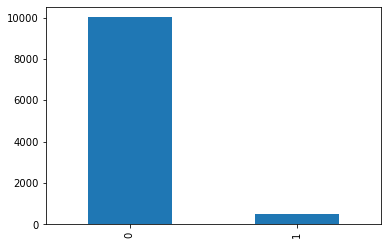

In [244]:
pd.Series(y).value_counts().plot(kind='bar')

# Oversampling the data using SMOTE

#### To balance out the dataset, oversample the minority class with varaitions to be equal to the majority class

In [189]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_over_sampled, y_over_sampled = oversample.fit_resample(X, y)

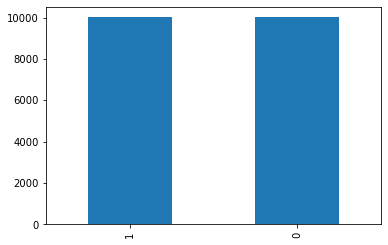

In [243]:
pd.Series(y_over_sampled).value_counts().plot(kind='bar')

## Create a hold out validation set to use after model selection 

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(X_over_sampled, y_over_sampled, 
                                                                    test_size=0.20, random_state=42)

In [245]:
X_train.shape

(16012, 64)

In [246]:
X_holdout_test.shape

(4004, 64)

# Model Selection Using AUC-ROC score

In [272]:
X_tv, X_test, y_tv, y_test = train_test_split(X_train, y_train)

models = [
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 200]
        }
    },
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(max_iter=10000),
        'params': {
            'C': np.logspace(-2, 0, 10)
        }
    },
    {
        'name': 'Gradient Boosting Classifier',
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': np.logspace(-2, 0, 3)
        }
    }
]

kfold = KFold(n_splits=5, shuffle=True)

for m in models:
    pipeline = make_pipeline(
        StandardScaler(),
        GridSearchCV(
            estimator=m['model'],
            param_grid=m['params'],
            scoring='roc_auc',
            n_jobs=-1,
            cv=kfold
        )
    )
    
    pipeline.fit(X_tv, y_tv)
    predictions = pipeline.predict(X_test)
    m['score'] = roc_auc_score(y_test, predictions, average='micro')
    m['pipeline'] = pipeline

In [273]:
for m in models:
    print(f"Model: {m['name']}: score = {m['score']:.4f}")

Model: Random Forest: score = 0.9731
Model: Logistic Regression: score = 0.7044
Model: Gradient Boosting Classifier: score = 0.9607


# The best model selected is Random Forest 

In [274]:
selected_model = RandomForestClassifier(n_estimators=200)
pipeline = make_pipeline(StandardScaler(), selected_model)

## How does the selected model perform on holdout data

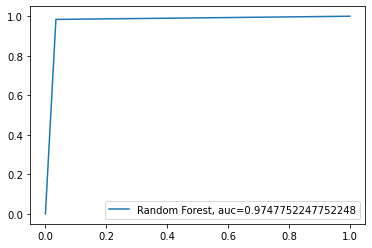

In [276]:
pipeline.fit(X_train, y_train)
predicitions = pipeline.predict(X_holdout_test)

fpr, tpr, _ = roc_curve(y_holdout_test, predicitions)
auc = roc_auc_score(y_holdout_test, predicitions)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Feature Importance

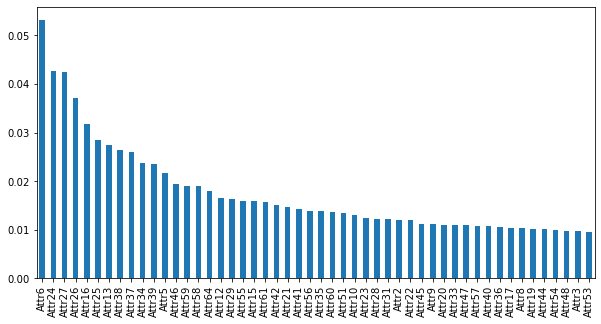

In [277]:
plt.subplots(figsize = (10,5))
feature_importances = pd.Series(selected_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False,inplace=True)
feature_importances.nlargest(50).plot(kind='bar')

### Parsing the meaning of features from text file

In [278]:
features_dict = {}
with open("features.txt") as f:
    for line in f:
        feature_key = line.split(" ", 1)[0].replace("X", "Attr")
        feature_name = line.split(" ", 1)[1]
        features_dict[feature_key] = feature_name

## Getting the meanings of top n features 

In [288]:
n_top_features = 20

top_n_feature_names = [features_dict[f].strip() for f in feature_importances.nlargest(n_top_features).index]
top_n_features = dict(zip(top_n_feature_names, feature_importances.nlargest(n_top_features)))

counter = 1
for i in top_n_features.keys():
    print(f"{counter}. {i}: {top_n_features[i]:.4f}")
    counter += 1

1. retained earnings / total assets: 0.0532
2. gross profit (in 3 years) / total assets: 0.0426
3. profit on operating activities / financial expenses: 0.0425
4. (net profit + depreciation) / total liabilities: 0.0372
5. (gross profit + depreciation) / total liabilities: 0.0317
6. (equity - share capital) / total assets: 0.0285
7. (gross profit + depreciation) / sales: 0.0274
8. constant capital / total assets: 0.0263
9. (current assets - inventories) / long-term liabilities: 0.0259
10. operating expenses / total liabilities: 0.0237
11. profit on sales / sales: 0.0235
12. [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365: 0.0216
13. (current assets - inventory) / short-term liabilities: 0.0195
14. long-term liabilities / equity: 0.0190
15. total costs /total sales: 0.0190
16. sales / fixed assets: 0.0179
17. gross profit / short-term liabilities: 0.0164
18. logarithm of total assets: 0.0164
19. working capital: 0.0159
20

#### From the feature importance plot, we can observe that around top 20 features contribute mainly. We can further verify this using PCA

# Principal Component Analysis

In [292]:
percentage_variance_explained = 0.99

pca_pipeline = make_pipeline(StandardScaler(), PCA(percentage_variance_explained)) 
pca_pipeline.fit_transform(X_over_sampled)

print(f"{pca.n_components_} principal components define {percentage_variance_explained * 100}% of the variance")

8 principal components define 99.0% of the variance


## train a model on the top n features

In [296]:
pipeline.fit(X_train[feature_importances.nlargest(n_top_features).index], y_train)
top_n_model_predicitions = pipeline.predict(X_holdout_test[feature_importances.nlargest(n_top_features).index])
print(f"Using top {n_top_features} features")

Using top 20 features


## Model performance on top n features

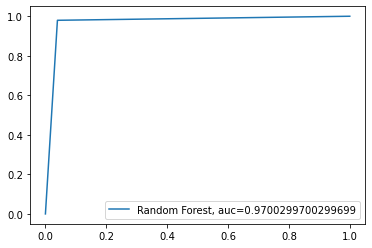

In [297]:
fpr, tpr, _ = roc_curve(y_holdout_test, top_n_model_predicitions)
auc = roc_auc_score(y_holdout_test, top_n_model_predicitions)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)
plt.show()